Parameters used in the code:

N: Number of sites in the transverse field Ising model.

This code optimizes only 8 sites because we are using SciPy with a CPU, which is slow but suitable for a toy model.

B: B-field value for the target Hamiltonian, which can be zero or non-zero.

J_value: J coupling strength.

J_matrix_alpha: Power-law decay constant.

number_of_layers: The number of steps in the optimization.

The convergence threshold or learning rate can be adjusted using SciPy’s arguments. More details can be found here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

The final output file name is f'scipy_lambda_result_N={N}_B={B}_layers{number_of_layers}.txt'.

In [1]:
# initialize variables
N = 8 
B = 0.1
J_value = 1
J_matrix_alpha =  1
number_of_layers = 10

In [2]:
import numpy as np
from scipy.sparse.linalg import eigs
from numpy import linalg as LA
from scipy.interpolate import Akima1DInterpolator
from scipy.linalg import expm
import time
from scipy import sparse
import matplotlib.pyplot as plt
import pandas
import scipy
np.set_printoptions(precision=6)
# Q is the dimension
Q = pow(2, N)

# decimal number to binary array function
def D2B(num):
    string = f'{num:1b}'
    result = np.zeros(N - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# decimal number to binary array function
def D2B_with_digit(num,digit):
    string = f'{num:1b}'
    result = np.zeros(digit - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

def spin_reflection(array):
    new_array = np.zeros(len(array),dtype=int)
    for i in range(len(array)):
        if array[i] == 1:
            new_array[i] = 0
        else:
            new_array[i] = 1
    return new_array

def spatial_reflection(array):
    new_array = array[::-1]
    return new_array

# start my main function

# initialize J matrix
J_matrix = np.zeros((N, N), dtype='float64')
for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)

In [3]:
# start to get what product states are having the same symmtries
loop_state_list = np.linspace(0,Q-1,num=Q,dtype=int)

couple_state_matrix = []
sign_matrix = []
# this is the final result for the states to consctruct basis 

for n in range(Q):  # n is an unused index
    
    # couple_num_list would be my result for each state we loop
    
    if len(loop_state_list)!=0: # loop for couple number for one state
                
        couple_num_list = [] # this is the list to store all the number that couple to the number we are looping
        couple_num_list = np.array(couple_num_list, dtype=int)
        state_num = loop_state_list[0]
        couple_num_list = np.append(couple_num_list,state_num)
        
        for m in range(Q): # loop for spin and spatial for all states inside the couple number list
            
            if m==0:
                
                couple_num_list_old =couple_num_list
                
                for i in range(len(couple_num_list)):
                    number = couple_num_list[i]
                    array = D2B(number)

                    # spin reflection 
                    spin_relfection_array = spin_reflection(array)
                    spin_number = B2D(spin_relfection_array)
                    couple_num_list =np.append(couple_num_list,spin_number)


                    # spatial reflection 
                    spatial_relfection_array = spatial_reflection(array)
                    spatial_number = B2D(spatial_relfection_array)
                    couple_num_list =np.append(couple_num_list,spatial_number)
                    
                    # remove the repeated element 
                    couple_num_list = np.unique(couple_num_list)
            else:
                
                if len(couple_num_list_old) != len(couple_num_list):
                    # update couple_num_list_old first 
                    couple_num_list_old =couple_num_list
                    
                    for i in range(len(couple_num_list)):
                        number = couple_num_list[i]
                        array = D2B(number)

                        # spin reflection 
                        spin_relfection_array = spin_reflection(array)
                        spin_number = B2D(spin_relfection_array)
                        couple_num_list =np.append(couple_num_list,spin_number)
                        
                        
                        # spatial reflection 
                        spatial_relfection_array = spatial_reflection(array)
                        spatial_number = B2D(spatial_relfection_array)
                        couple_num_list = np.append(couple_num_list,spatial_number)
                        
                        # remove the repeated element 
                        couple_num_list = np.unique(couple_num_list)
                        
        # now we have final couple_num_list
        couple_state_matrix.append(couple_num_list.tolist())
        
        # remove the ones already found 
        for j in range(len(couple_num_list)):
            loop_state_list = np.delete(loop_state_list, np.where(loop_state_list ==couple_num_list[j] ))

In [4]:
# initialize H matrix
couple_dimen = len(couple_state_matrix)

HA_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')
HB_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')

In [5]:
print('the dimension of the subspace hamiltonian is ',couple_dimen)

the dimension of the subspace hamiltonian is  72


In [6]:
# loop each basis to fill in the diagonal elements for HA matrix 

for i in range(couple_dimen):
    
    state_array = np.array( couple_state_matrix[i] )
    
    # loop each element inside the array 
    normalization = len(state_array)
    
    # energy total for all the product states inside one basis
    
    e_tot = 0
    for j in range(len(state_array)):
        
        state = D2B(state_array[j])
        
        # loop over N sites to change the state vector to either 1 or -1
        
        for k in range(N):
            # 1 is spin down , 0 is spin up
            if state[k] == 1:
                state[k] = -1
            else:
                state[k] = 1

        # now get the energy, loop all the sites and then pairs
        
        for m in range(N):
            for q in range(N):
                e_temp = J_matrix[m][q] * state[m] * state[q]
                e_tot = e_tot + e_temp

    HA_matrix[i][i] = e_tot/normalization

In [7]:
# generate vector form for each basis
vector_form_basis_matrix = np.zeros((couple_dimen,Q))

for i in range(couple_dimen):
    
    state_array = np.array( couple_state_matrix[i] )
    normalization = np.sqrt(len(state_array))
    
    for j in state_array:
        vector_form_basis_matrix[i][j] = 1
        
    # put back normalization factor
    vector_form_basis_matrix[i] = vector_form_basis_matrix[i]/normalization
    
    

In [8]:
# loop each basis to fill in HB matrix 

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # this is the actual normalization unlike before since it will couple to some other states
    # so it can not be like just the square like we did before
    normalization = np.sqrt(len(state_array))

    # loop each product state to generate N other states, i.e. generaete the state after operator acting on it
    result_num_list = []
    result_num_list = np.array(result_num_list,dtype=int)
    for k in range(len(state_array)):
        
        spin = D2B(state_array[k])

        # start fliping the spins
        for j in range(N):
            if spin[j] == 1:
                # if it's spin down, raise to spin up
                spin[j] = 0
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 1
            else:
                # if it's spin down, raise to spin up
                spin[j] = 1
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 0
        
     
    # generate the vector form for the state after operrator acting on it
    
    vector_final_state = np.zeros(Q)
    
    for j in result_num_list:
        vector_final_state[j] = vector_final_state[j] +1
        
    # put back normalization factor 
    vector_final_state = vector_final_state/normalization
    
    # calculate dot product to put into inside the matrix
    for j in range(couple_dimen):
        
        dot_product = np.dot(vector_final_state,vector_form_basis_matrix[j])
        HB_matrix[i][j] = dot_product

In [9]:
# get true ground state 
w, v = LA.eigh(HA_matrix + B* HB_matrix)
inx = np.argsort(w)
true_gs_vec = v[:, inx[0]]
true_gs_energy =w[0]
E_max =w[-1]

In [10]:
print('true ground state energy is', true_gs_energy)

true ground state energy is -5.110650491789136


In [11]:
# get  ground state with initial H_B Hamiltonian 
w, v = LA.eigh(HB_matrix)
inx = np.argsort(w)
temp_vec = v[:, inx[0]] # the index here could be zero or one, depending on the parity
# but if the wrong index will always give roughly zero fidelity 

In [12]:
# get initial fidelity
fidelity_t_0 = pow(np.dot(true_gs_vec,temp_vec),2) # all real so no need to c.c.
print('fidelity before optim is', fidelity_t_0)

fidelity before optim is 0.016242148889510737


In [13]:
def get_energy(H_matrix,state):
    
    a = np.dot(H_matrix,state)
    energy = np.dot(np.conjugate(state),a).real

    return energy

In [14]:
def get_fidelity(gs,state):
    
    dp = np.dot(gs,state) # dp is dot product
    #print(dp)
    dp_cc = np.conjugate(dp)     # the complex conjucate of the dot product 
    return (dp*dp_cc).real

In [15]:
target_H = np.copy(HA_matrix + B* HB_matrix)

In [16]:
def lambda_evolve(x):
    # global fidelity
    # final_fidelity_list =[]
    # final_fidelity_list.append(fidelity_t_0)
    # product state
    p = temp_vec  # p stands for product
     # loop each time step
    for i in range(number_of_layers):
        H_matrix = HA_matrix + x[i+number_of_layers]*HB_matrix
        exp_imgH_matrix = expm( -1*1j*x[i]*H_matrix )
        new_p = np.dot(exp_imgH_matrix,p)
        # update state
        p = new_p
        
    # get fidelity 
    # fidelity = get_fidelity(true_gs_vec,p)
    #print('fidelity is ',fidelity)
    # get energy
    energy = get_energy(target_H,p)
    #return -1*fidelity
    return energy

In [17]:
def lambda_evolve_fidelity_list(x):
    fidelity_list= []
    inst_f_list=[]
    p = temp_vec  # p stands for product
     # loop each time step
    for i in range(number_of_layers):            
        H_matrix = HA_matrix + x[i+number_of_layers]*HB_matrix
        # inst H
        if x[i]<0 and x[i+number_of_layers]<0:
            print('both smaller than zero',i)
            w, v = LA.eigh( -HA_matrix - x[i+number_of_layers]*HB_matrix)
            inst_gs_vec = v[:,0]
        else:
            w, v = LA.eigh( HA_matrix + x[i+number_of_layers]*HB_matrix)
            inst_gs_vec = v[:,0]
            
        exp_imgH_matrix = expm( -1*1j*x[i]*H_matrix )
        new_p = np.dot(exp_imgH_matrix,p)
        # update state
        p = new_p
        fidelity_list.append(get_fidelity(true_gs_vec,p))
        inst_f_list.append(get_fidelity(inst_gs_vec,p))
    return np.array(fidelity_list), np.array(inst_f_list)

In [18]:
# # this serves as a checking part only 
# # best result N=12,46 LAYERS,64 bits
# x_46 =np.array([ 0.097725,  0.477288,  0.443276,  0.172682,  1.246086,  0.880701,
#         0.311077,  0.343559,  0.4446  ,  0.498634,  3.513766,  2.195835,
#        -1.679474,  2.34228 ,  1.033489,  3.00999 , -0.583254, -1.904584,
#         6.23439 ,  0.627215,  0.72342 ,  0.945287,  0.84764 ,  2.777252,
#         0.920419,  0.795509,  0.771761,  1.074029,  0.849288,  0.778886,
#         2.109009,  2.799745,  2.618029,  9.436081, -6.322151,  9.304835,
#         0.817901,  0.557422,  0.670992,  0.875811,  5.658462, -0.068928,
#         0.289072,  5.464772,  2.425481,  1.070671, 23.078089,  7.676801,
#         4.609007,  3.1356  ,  2.488154,  2.080197,  1.473614,  1.071259,
#         0.827909,  0.710397,  0.655159,  0.635309,  0.610464,  0.589641,
#         0.570621,  0.552939,  0.528794,  0.507812,  0.486003,  0.456375,
#         0.418009,  0.388989,  0.374755,  0.359278,  0.349239,  0.336304,
#         0.314521,  0.293763,  0.279373,  0.261307,  0.24796 ,  0.243052,
#         0.236972,  0.232609,  0.236054,  0.227522,  0.218561,  0.199195,
#         0.179152,  0.151823,  0.135518,  0.330649,  0.170398,  0.117737,
#         0.115771,  0.107222])
# number_of_layers=46
# a,b=lambda_evolve_fidelity_list(x_46)

In [19]:
Nfeval = 1
filename = f'scipy_lambda_B_training_log_N={N}_B={B}_layers_{number_of_layers}.txt'
def callback(intermediate_result):
    global Nfeval
    global energy_list
    energy =intermediate_result.fun
    # Print information
    print(f'{Nfeval:4d}   Energy: {energy:.6f}')
    
    # Write information to a file
    with open(filename, 'a') as f:
        f.write(f'{energy:.6f},')
    
    Nfeval += 1

In [20]:
def exp_decay_guess_new(B_0, B_f, j):
    tau = np.log(B_0 / B_f)
    value = B_0 * np.exp(-j * tau / (number_of_layers - 1))  # Adjust for exact B_0 and B_f
    return value

# Parameters
B_0 = 1                 # Initial value (starts here)
B_f = 0.1               # Final value (ends here)
# Generate B_guess using the new method
layer_indices = np.arange(0, number_of_layers)  # Adjust indices to go from 0 to number_of_layers - 1
B_guess = np.array([exp_decay_guess_new(B_0, B_f, j) for j in layer_indices])

lambada_guess = np.random.uniform(1,2,number_of_layers)
x = np.concatenate((lambada_guess, B_guess))

######################################################################################################
# the first len(number_of_layers) parameters are the lambda field parameter while the rest is for the B field 

In [21]:
# If one wish to run optim with bounds, the followings can do that with L-BFGS-B
######################################################################################################
# bounds =[]
# for j in range(number_of_layers):
#     bounds.append((0,4))
# for j in range(number_of_layers):
#     bounds.append((0,10))
# result = scipy.optimize.minimize(lambda_evolve,x,method='L-BFGS-B',callback=lambda xk: callbackF(xk, x),tol=1e-30,bounds=bounds)

######################################################################################################

# In the paper, we mainly just use BFGS without bounds

result = scipy.optimize.minimize(lambda_evolve,x,method='BFGS',callback=callback,options={'gtol': 1e-5})

# the callback function will return energy value during each iteration 

   1   Energy: -4.398952
   2   Energy: -4.535576
   3   Energy: -4.583663
   4   Energy: -4.650343
   5   Energy: -4.721795
   6   Energy: -4.745749
   7   Energy: -4.759519
   8   Energy: -4.771771
   9   Energy: -4.789429
  10   Energy: -4.813039
  11   Energy: -4.825057
  12   Energy: -4.838619
  13   Energy: -4.856074
  14   Energy: -4.881077
  15   Energy: -4.899299
  16   Energy: -4.918554
  17   Energy: -4.926403
  18   Energy: -4.938882
  19   Energy: -4.954262
  20   Energy: -4.967545
  21   Energy: -4.987659
  22   Energy: -5.009708
  23   Energy: -5.018771
  24   Energy: -5.030076
  25   Energy: -5.036031
  26   Energy: -5.045060
  27   Energy: -5.055228
  28   Energy: -5.057305
  29   Energy: -5.060667
  30   Energy: -5.064449
  31   Energy: -5.066430
  32   Energy: -5.069556
  33   Energy: -5.072574
  34   Energy: -5.073247
  35   Energy: -5.074251
  36   Energy: -5.075540
  37   Energy: -5.076887
  38   Energy: -5.078068
  39   Energy: -5.078757
  40   Energy: -5.079364


In [22]:
# Function to save the result into a file
def save_result_to_file(result, filename):
    with open(filename, 'w') as f:
        f.write(f"message: {result.message}\n")
        f.write(f"success: {result.success}\n")
        f.write(f"status: {result.status}\n")
        f.write(f"fun: {result.fun}\n")
        f.write(f"x: {result.x.tolist()}\n")
        f.write(f"nit: {result.nit}\n")
        f.write(f"jac: {result.jac.tolist()}\n")
        f.write(f"hess_inv: {result.hess_inv.tolist()}\n")
        f.write(f"nfev: {result.nfev}\n")
        f.write(f"njev: {result.njev}\n")

# Save the result
save_result_to_file(result,f'scipy_lambda_result_N={N}_B={B}_layers_{number_of_layers}.txt')

In [23]:
optim_fidelity_list, optim_inst_f_list = lambda_evolve_fidelity_list(result.x)

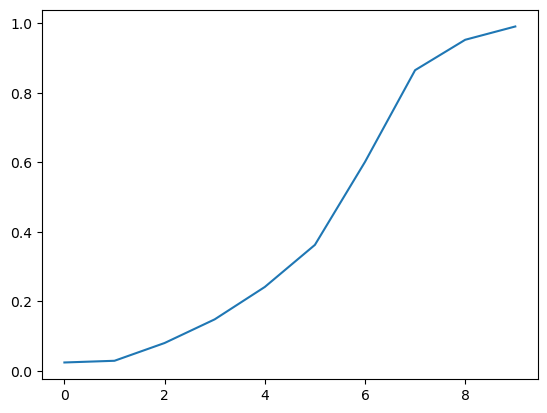

In [24]:
# plot the fidelity during modulated time evolution 
plt.plot(optim_fidelity_list)

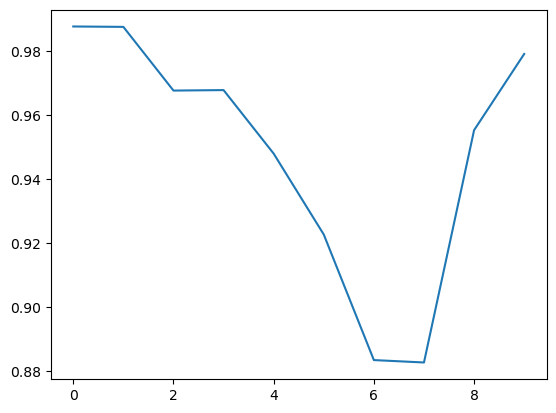

In [25]:
# plot the instantaneous fidelity during modulated time evolution 
plt.plot(optim_inst_f_list)